In [1]:
from datetime import datetime
from dateutil import parser
import calendar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import itertools
import math

import re
import nltk
import os
from collections import Counter

In [2]:
## Get list of stopwords from NLTK package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\preston\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Functions

### Cleaning and variable creation

In [3]:
def clean_tweets(df, startdate = 20200811, no_stops = True):

    ## Define dataframe and filter by date
    df = df[['id', 'date', 'tweet']]
    df = df[df.index > parser.parse(str(startdate))]
    
    ## Clean tweets
    clean_text = []

    for tweet in df.tweet:
        # Remove URLS
        tweet = re.sub("(\w+:\/\/\S+)", " ", tweet)
        # Replace non-characters with spaces
        tweet = re.sub("\W", " ", tweet)
        # Remove digits
        tweet = re.sub("[0-9]", "", tweet)
        # Remove extra spaces
        tweet = re.sub("\s+", " ", tweet)
        tweet = re.sub("^\s+", "", tweet)
        tweet = re.sub("\s+$", "", tweet)
            
        clean_text.append(tweet.lower())

    ## Add updated text to main data
    df['clean_text'] = clean_text
    df['term_list'] = df['clean_text'].apply(lambda x: x.split())
    
    ## Remove stop words from tweets
    if no_stops == True:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        
        for term_list in df['term_list']:
            for term in term_list:
                if term in stop_words:
                    term_list.remove(term)
    
    return df

In [4]:
def computeTF(x):
    
    wordFreq = x[1]
    wordList = x[0]
    bagOfWordsCount = len(wordList)
    
    tfDict = {}
    for word, count in wordFreq.items():
        tfDict[word] = count / float(bagOfWordsCount)
        
    return Counter(tfDict)

In [5]:
def term_counter(txt_list):
    
    term_counts = {}
    for i in set(txt_list):
        term_counts[i] = txt_list.count(i)
        
    return(Counter(term_counts))

In [6]:
def return_term_count_list(df, term_count_column = "term_count"):
   
    term_count_list = []
    for i in df[term_count_column]:
        term_count_list.append(dict(i))
        
    return(term_count_list)

In [7]:
def return_corpus_set(df, term_list_column = "term_list"):
    
    tweet_corpus = []
    for i in df[term_list_column]:
        tweet_corpus += i

    return(set(tweet_corpus))

In [8]:
def computeIDF(documents, corpus_set):
    N = len(documents)

    idfDict = dict.fromkeys(corpus_set, 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log(N / (float(val)))
        
    return(Counter(idfDict))

In [9]:
def computeTFIDF(TF,idfs):
    
    tfidf = {}
    for word, val in TF.items():
        tfidf[word] = val * idfs[word]
        
    return(Counter(tfidf))

In [10]:
def TFIDF_processing(df):
    
    df = clean_tweets(df)

    # Create dictionary of term counts for each tweet
    df['term_count'] = df['term_list'].apply(lambda x: term_counter(x))
    
    # Calculate term frequency (TF)
    df['TF'] = df[['term_list', 'term_count']].apply(computeTF, axis = 1)
    
    # Return corpus and doc list
    term_count_list_df = return_term_count_list(df)
    corpus_set_df = return_corpus_set(df)
    
    # Calculate IDF and  TF-IDF
    df_idf = computeIDF(term_count_list_df, corpus_set_df)
    df['TFIDF'] = df['TF'].apply(lambda x: computeTFIDF(x, df_idf))
    
    return(df, df_idf, corpus_set_df)

### TFIDF organization

In [11]:
def sum_normalize_collections(counter_list):
    
    counter_sum = Counter()
    for counter in counter_list:
        counter_sum += counter
        
    for k,v in counter_sum.items():
        counter_sum[k] = v/len(counter_list)
        
    return(counter_sum.most_common())

In [12]:
def TFIDF_vecorization(df,corpus):
    
    D = np.zeros((len(df), len(corpus)))

    for i,tfidf in enumerate(df["TFIDF"]):
        for term in tfidf:
            ind = (list(corpus)).index(term)
            D[i][ind] = tfidf[term]
            
    return(D)

In [13]:
def get_day_tfidf(df, date):
    day = pd.DataFrame(df.loc[date][0])
    idx = pd.DatetimeIndex([date] * len(day))
    
    day.index = idx
    day.columns = ['words', 'TFIDF']
    
    return(day)

In [14]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window) / window
    
    sma = np.convolve(values, weights, 'valid')
    
    return sma

---

# Data

## Twitter Data

In [15]:
## Import Biden data
biden_df = pd.read_csv('../data/biden.csv', index_col = 'date', parse_dates = True)
biden_df.index.rename("datetime", inplace = True)

## Date variables
biden_df['date'] = biden_df.index.date
biden_df['month'] = biden_df.index.month

biden_df.head()

,Unnamed: 0,id,conversation_id,created_at,timezone,place,tweet,language,hashtags,cashtags,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,date,month
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-09 14:40:00,0,1325885871875190784,1325885871875190784,1.604951e+12,-500,NaN,The bottom line: I will spare no effort to tur...,en,[],[],...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2020-11-09,11
2020-11-09 14:17:00,1,1325880083618426881,1325880083618426881,1.604949e+12,-500,NaN,The challenge before us right now is still imm...,en,[],[],...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2020-11-09,11
2020-11-09 13:50:00,2,1325873288711712769,1325873288711712769,1.604948e+12,-500,NaN,My COVID-19 Transition Advisory Board will adv...,en,[],[],...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2020-11-09,11
2020-11-09 13:37:00,3,1325870017401905152,1325870017401905152,1.604947e+12,-500,NaN,"Today, I have named a COVID-19 Transition Advi...",en,[],[],...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2020-11-09,11
2020-11-09 11:46:50,4,1325842292444291072,1325842292444291072,1.604940e+12,-500,NaN,I spent the morning with the co-chairs of my C...,en,[],[],...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,2020-11-09,11


In [16]:
## Import Biden data
trump_df = pd.read_csv('../data/trump.csv', index_col = 'date', parse_dates = True)
trump_df.index.rename("datetime", inplace = True)

## Date variables
trump_df['date'] = trump_df.index.date
trump_df['month'] = trump_df.index.month

## Match variable names to Biden
trump_df.rename(columns = {'text' : 'tweet'}, inplace = True)

trump_df.head()

,id,tweet,isRetweet,isDeleted,device,favorites,retweets,date,month
datetime,,,,,,,,,
2011-08-02 18:07:48,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02,8
2020-03-03 01:34:50,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,3
2020-01-17 03:22:47,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,1
2020-09-12 20:10:58,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,9
2020-01-17 13:13:59,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,1


### Process Twitter data

In [17]:
## Calculate TFIDFs for Biden
biden_df, biden_idf,biden_corpus = TFIDF_processing(biden_df)
biden_df.head()

,id,date,tweet,clean_text,term_list,term_count,TF,TFIDF
datetime,,,,,,,,
2020-11-09 14:40:00,1325885871875190784,2020-11-09,The bottom line: I will spare no effort to tur...,the bottom line i will spare no effort to turn...,"[bottom, line, will, spare, effort, turn, pand...","{'turn': 1, 'effort': 1, 'around': 1, 'bottom'...","{'turn': 0.125, 'effort': 0.125, 'around': 0.1...","{'turn': 0.6492187733637008, 'effort': 0.71917..."
2020-11-09 14:17:00,1325880083618426881,2020-11-09,The challenge before us right now is still imm...,the challenge before us right now is still imm...,"[challenge, us, right, still, immense, growing...","{'so': 1, 'us': 1, 'need': 1, 'bold': 1, 'imme...","{'so': 0.07142857142857142, 'us': 0.0714285714...","{'so': 0.33869750451189634, 'us': 0.1645270306..."
2020-11-09 13:50:00,1325873288711712769,2020-11-09,My COVID-19 Transition Advisory Board will adv...,my covid transition advisory board will advise...,"[covid, transition, advisory, board, advise, d...","{'bedrock': 1, 'compassion': 1, 'american': 1,...","{'bedrock': 0.05, 'compassion': 0.05, 'america...","{'bedrock': 0.356983016798246, 'compassion': 0..."
2020-11-09 13:37:00,1325870017401905152,2020-11-09,"Today, I have named a COVID-19 Transition Advi...",today i have named a covid transition advisory...,"[today, have, named, covid, transition, adviso...","{'biden': 1, 'comprised': 1, 'have': 1, 'i': 1...","{'biden': 0.03333333333333333, 'comprised': 0....","{'biden': 0.1204433270449586, 'comprised': 0.2..."
2020-11-09 11:46:50,1325842292444291072,2020-11-09,I spent the morning with the co-chairs of my C...,i spent the morning with the co chairs of my c...,"[spent, morning, co, chairs, my, covid, counci...","{'co': 1, 'going': 1, 'the': 1, 'move': 1, 're...","{'co': 0.041666666666666664, 'going': 0.041666...","{'co': 0.23042593431378414, 'going': 0.1320570..."


In [18]:
## Calculate TFIDF scores by date for Biden
biden_by_date = biden_df.groupby("date")["TFIDF"].apply(lambda x:x.to_list())

score_df_biden = pd.DataFrame(biden_df.groupby("date")["TFIDF"].apply(lambda x: sum_normalize_collections(x.to_list())))
score_df_biden.index = pd.DatetimeIndex(score_df_biden.index)

score_df_biden.head()

,TFIDF
date,
2020-08-11,"[(win, 0.17023225651338691), (go, 0.1407691758..."
2020-08-12,"[(kamalaharris, 0.12019153354319008), (work, 0..."
2020-08-13,"[(days, 0.3480363500813832), (kamalaharris, 0...."
2020-08-14,"[(story, 0.2673950433368432), (social, 0.20720..."
2020-08-15,"[(know, 0.08638426297938186), (kamalaharris, 0..."


In [19]:
## Calculate TFIDFs for Trump
trump_df, trump_idf, trump_corpus = TFIDF_processing(trump_df)
trump_df.head()

,id,date,tweet,clean_text,term_list,term_count,TF,TFIDF
datetime,,,,,,,,
2020-09-12 20:10:58,1304875170860015617,2020-09-12,The Unsolicited Mail In Ballot Scam is a major...,the unsolicited mail in ballot scam is a major...,"[unsolicited, mail, ballot, scam, major, threa...","{'numbers': 1, 'elections': 1, 'ballot': 1, 's...","{'numbers': 0.02857142857142857, 'elections': ...","{'numbers': 0.14356628368823462, 'elections': ..."
2020-10-23 22:04:14,1319761576996573186,2020-10-23,THANK YOU to all of the Great American Patriot...,thank you to all of the great american patriot...,"[thank, to, of, great, american, patriots, the...","{'villages': 1, 'to': 1, 'the': 1, 'great': 1,...","{'villages': 0.1, 'to': 0.1, 'the': 0.1, 'grea...","{'villages': 0.8069342366811636, 'to': 0.32735..."
2020-10-12 22:22:39,1315779944002199552,2020-10-12,"“I’m running as a proud Democrat, for the Sena...",i m running as a proud democrat for the senate...,"[m, running, a, proud, democrat, the, senate, ...","{'going': 1, 'the': 1, 'biden': 1, 'is': 1, 'g...","{'going': 0.045454545454545456, 'the': 0.04545...","{'going': 0.16760526055171607, 'the': 0.056441..."
2020-10-23 19:50:48,1319727996882702336,2020-10-23,https://t.co/LCQcdlRkhz,,[],{},{},{}
2020-10-23 19:49:55,1319727773234069505,2020-10-23,https://t.co/4V7nu5hh8V,,[],{},{},{}


In [20]:
## Calculate TFIDF scores by date for Trump
trump_by_date = trump_df.groupby("date")["TFIDF"].apply(lambda x:x.to_list())

score_df_trump = pd.DataFrame(trump_df.groupby("date")["TFIDF"].apply(lambda x: sum_normalize_collections(x.to_list())))
score_df_trump.index = pd.DatetimeIndex(score_df_trump.index)

score_df_trump.head()

,TFIDF
date,
2020-08-11,"[(p, 0.15673591337924378), (conference, 0.1448..."
2020-08-12,"[(bus, 0.19383381382606418), (usdot, 0.1658985..."
2020-08-13,"[(realdonaldtrump, 0.11854035904679111), (cham..."
2020-08-14,"[(thank, 0.06761070302064548), (rt, 0.05144181..."
2020-08-15,"[(lizrnc, 0.15307056535818572), (terrible, 0.1..."


score_df_joe.to_csv('../../data/biden_tweet_scores.csv')
score_df_donald.to_csv('../../data/trump_tweet_scores.csv')

## Polling Data

### Pull polling data

In [21]:
# Read in data, select relevant cols
cols = ['poll_id', 'fte_grade', 'sample_size', 'start_date', 'answer', 'pct']
ge = pd.read_csv('../data/president_polls.csv', usecols = cols, index_col = 'start_date', parse_dates = True)

### Clean polling data

In [22]:
# Only use good polls (according to 538)
ge = ge[ge['fte_grade'].isin(['A+', 'A', 'A-', 'A/B', 'B+', 'B'])]
ge.drop('fte_grade', axis = 1, inplace = True)

In [23]:
# Check to see the latest date with primary candidates still.
lastdate = ge[ge['answer'] == 'Sanders'].index.values[0]

In [24]:
# Drop all primary dates, only need Biden and Trump
ge = ge[ge.index > lastdate]
ge = ge[ge.answer.isin(['Biden', 'Trump'])]

In [25]:
# Use a pivot table to get Biden and Trump pct in the same row
runoff = ge.pivot_table('pct', ['start_date', 'poll_id', 'sample_size'], 'answer').reset_index().set_index('start_date')
runoff

answer,poll_id,sample_size,Biden,Trump
start_date,,,,
2020-04-10,65918,1200.0,44.0,49.0
2020-04-12,65756,1166.0,48.0,43.0
2020-04-13,65781,900.0,49.0,42.0
2020-04-14,65761,1318.0,48.0,47.0
2020-04-16,65841,1385.0,46.0,42.0
...,...,...,...,...
2020-10-30,72619,1501.0,49.0,41.0
2020-10-31,72714,1363.0,53.0,43.0
2020-10-31,72714,1500.0,49.0,40.0


In [26]:
# Weight percentages by sample sizes
runoff['total_biden'] = runoff['Biden'] * runoff['sample_size']
runoff['total_trump'] = runoff['Trump'] * runoff['sample_size']

election_cleaned = runoff.groupby('start_date')[['sample_size', 'total_biden', 'total_trump']].sum().sort_index()
election_cleaned['w_biden'] = election_cleaned['total_biden'] / election_cleaned['sample_size']
election_cleaned['w_trump'] = election_cleaned['total_trump'] / election_cleaned['sample_size']
election_cleaned.head()

answer,sample_size,total_biden,total_trump,w_biden,w_trump
start_date,,,,,
2020-04-10,1200.0,52800.0,58800.0,44.000000,49.000000
2020-04-12,1166.0,55968.0,50138.0,48.000000,43.000000
2020-04-13,900.0,44100.0,37800.0,49.000000,42.000000
2020-04-14,1318.0,63264.0,61946.0,48.000000,47.000000
2020-04-16,2020.0,98000.0,82300.0,48.514851,40.742574


---

# Figures

In [27]:
## Find month names for labelling
months = election_cleaned.index.month

month_names = [calendar.month_name[m] for m in set(months)]
month_names

['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']

In [28]:
np.arange(len(election_cleaned), step = len(election_cleaned)/len(month_names))

array([  0.   ,  20.125,  40.25 ,  60.375,  80.5  , 100.625, 120.75 ,
       140.875])

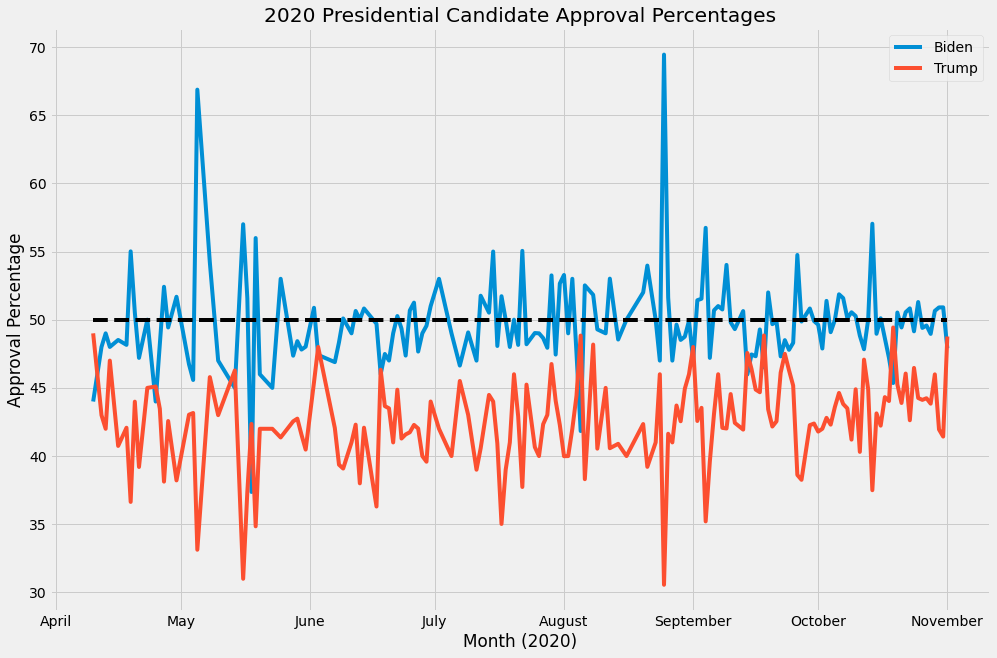

In [29]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xticklabels(month_names)

plt.plot(election_cleaned.index, election_cleaned['w_biden'], label = 'Biden')
plt.plot(election_cleaned.index, election_cleaned['w_trump'], label = 'Trump')
plt.plot(election_cleaned.index, [50 for i in election_cleaned.index], '--' ,color = 'black')

plt.xlabel('Month (2020)')
plt.ylabel('Approval Percentage')
plt.title('2020 Presidential Candidate Approval Percentages')
plt.legend()

plt.savefig('../output/overall_approval.png', bbox_inches = 'tight')
plt.show()

## October analysis

In [30]:
#month analysis from October1-November1
oct_nov = election_cleaned[election_cleaned.index >= '2020-10-01']

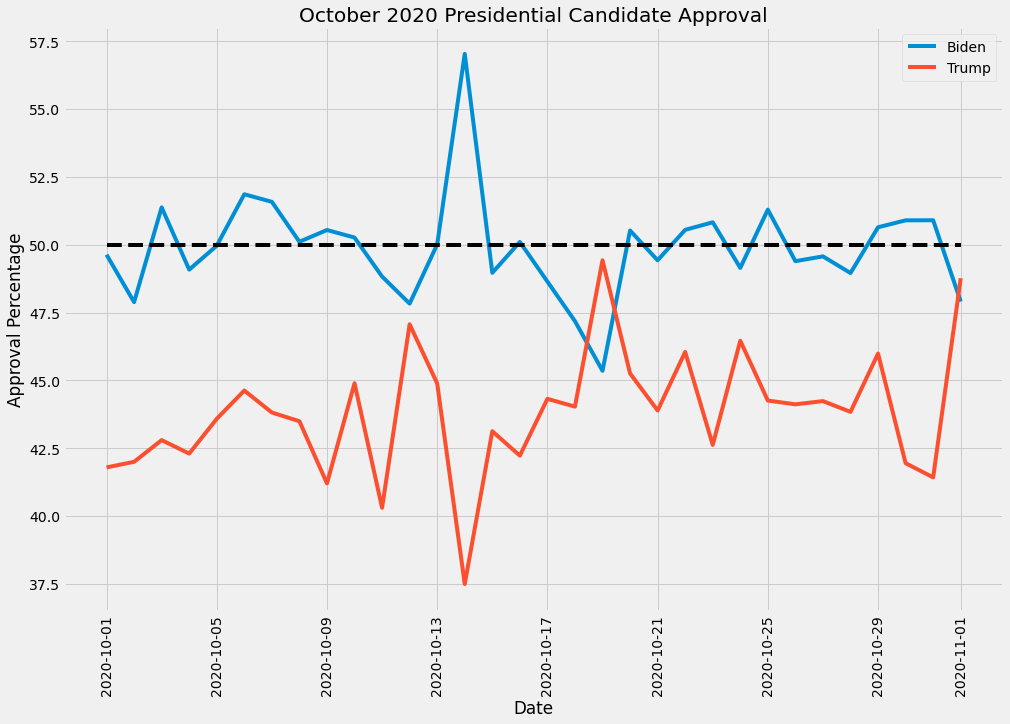

In [31]:
fig, ax = plt.subplots(figsize = (15,10))

plt.plot(oct_nov.index, oct_nov['w_biden'], label = 'Biden')
plt.plot(oct_nov.index, oct_nov['w_trump'], label = 'Trump')
plt.plot(oct_nov.index, [50]*len(oct_nov), '--', color = 'black')

plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Approval Percentage')
plt.title('October 2020 Presidential Candidate Approval')
plt.legend()

plt.savefig('../output/oct_approval.png', bbox_inches = 'tight')
plt.show()

## Twitter Figures

### TFIDF scores for August 11

In [32]:
day1_biden = get_day_tfidf(score_df_biden, '2020-08-11')

day1_biden.head()

,words,TFIDF
2020-08-11,win,0.170232
2020-08-11,go,0.140769
2020-08-11,kamalaharris,0.137411
2020-08-11,let,0.109078
2020-08-11,biggest,0.059931


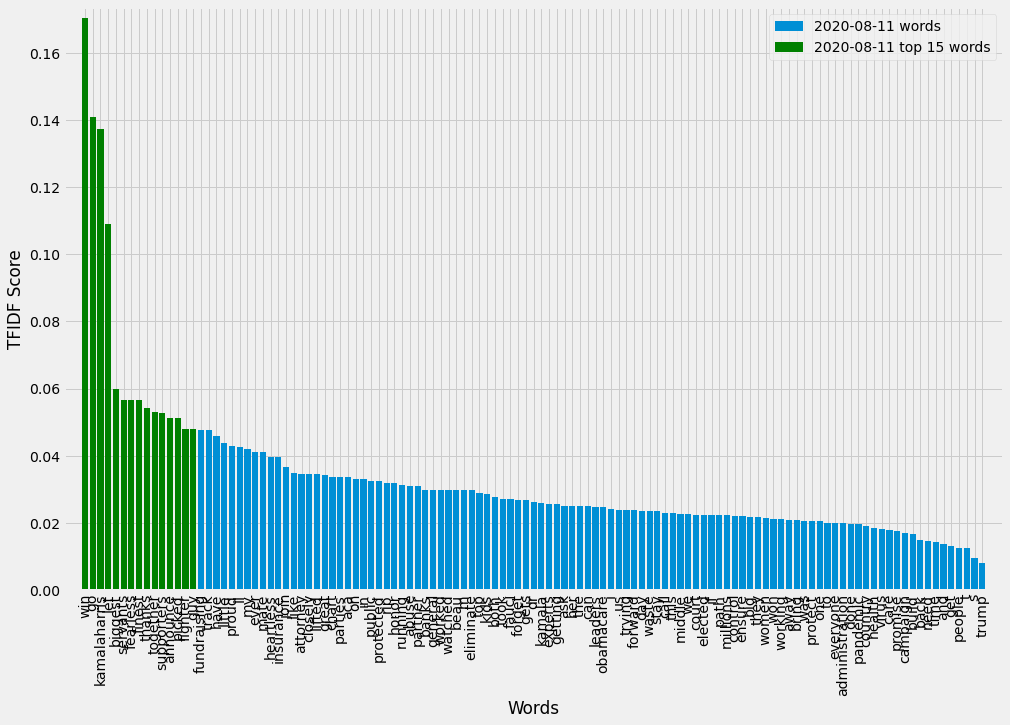

In [33]:
fig, ax = plt.subplots(figsize = (15,10))

plt.bar(day1_biden.words, day1_biden.TFIDF, label = str("2020-08-11") + ' words')
plt.bar(day1_biden.words[0:15], day1_biden.TFIDF[0:15], color = 'green', label = str("2020-08-11") + ' top 15 words')

plt.margins(.02)
plt.xticks(rotation = 90)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 8)
plt.xlabel('Words')
plt.ylabel('TFIDF Score')
plt.legend()

plt.savefig('../output/words_20200811.png', bbox_inches = 'tight')
plt.show()

### Keywords by polling results

In [34]:
## Election results August and later
elec_post_aug = election_cleaned[election_cleaned.index >= '2020-08-11']

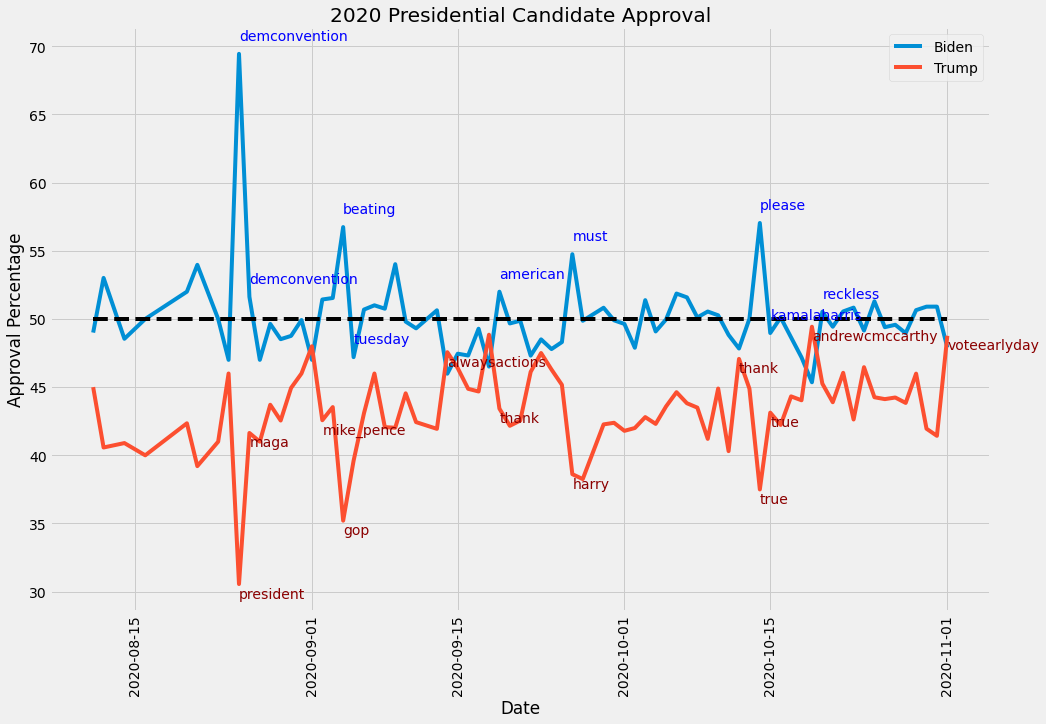

In [35]:
fig, ax = plt.subplots(figsize = (15, 10))

plt.plot(elec_post_aug.index, elec_post_aug['w_biden'], label = 'Biden')
plt.plot(elec_post_aug.index, elec_post_aug['w_trump'], label = 'Trump')
plt.plot(elec_post_aug.index, [50]*len(elec_post_aug), '--', color = 'black')

plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Approval Percentage')
plt.title('2020 Presidential Candidate Approval')
plt.legend()


## Add word labels to plot
for i in range(len(elec_post_aug)):
    
    largedelta = False
    
    if i > 0:
        largedelta = (np.abs(elec_post_aug['w_biden'][i] - elec_post_aug['w_biden'][i-1]) > 5)
        
    if largedelta:
        day = get_day_tfidf(score_df_biden, score_df_biden.index[i])
        label = day.sort_values("TFIDF", ascending = False).iloc[0]["words"]

        ax.annotate(label, (elec_post_aug.index[i], elec_post_aug['w_biden'][i] + 1), color='blue')

for k in range(len(elec_post_aug)):
    
    ## Shift to account for different start dates
    i = k + 0

    largedelta = False
    
    if i > 0:
        largedelta = (np.abs(elec_post_aug['w_trump'][i] - elec_post_aug['w_trump'][i-1]) > 5)
        
    if largedelta:
        day = get_day_tfidf(score_df_trump, score_df_trump.index[i])
        label = day.sort_values("TFIDF", ascending = False).iloc[0]["words"]

        ax.annotate(label, (elec_post_aug.index[k], elec_post_aug['w_trump'][k] - 1), color = 'darkred')
        
plt.savefig('../output/approval_words.png', bbox_inches = 'tight')
plt.show()

### Keywords by polling results (rolling averages)

In [36]:
## Calculate rolling averages for polling results
window = 7

running_avg_biden = movingaverage(elec_post_aug['w_biden'], window)
running_avg_trump = movingaverage(elec_post_aug['w_trump'], window)

In [37]:
## Manually select notable dates (days since start of August)
noteable_date_biden = [3, 7, 9, 12, 17, 19, 20, 22, 26, 32, 37, 39, 41, 46, 49, 50, 55, 57, 60, 62, 67]
noteable_date_trump = [3, 7, 9, 11, 13, 16, 20, 22, 27, 28, 31, 34, 38, 39, 44, 48, 50, 52, 55, 58, 61, 65, 67]

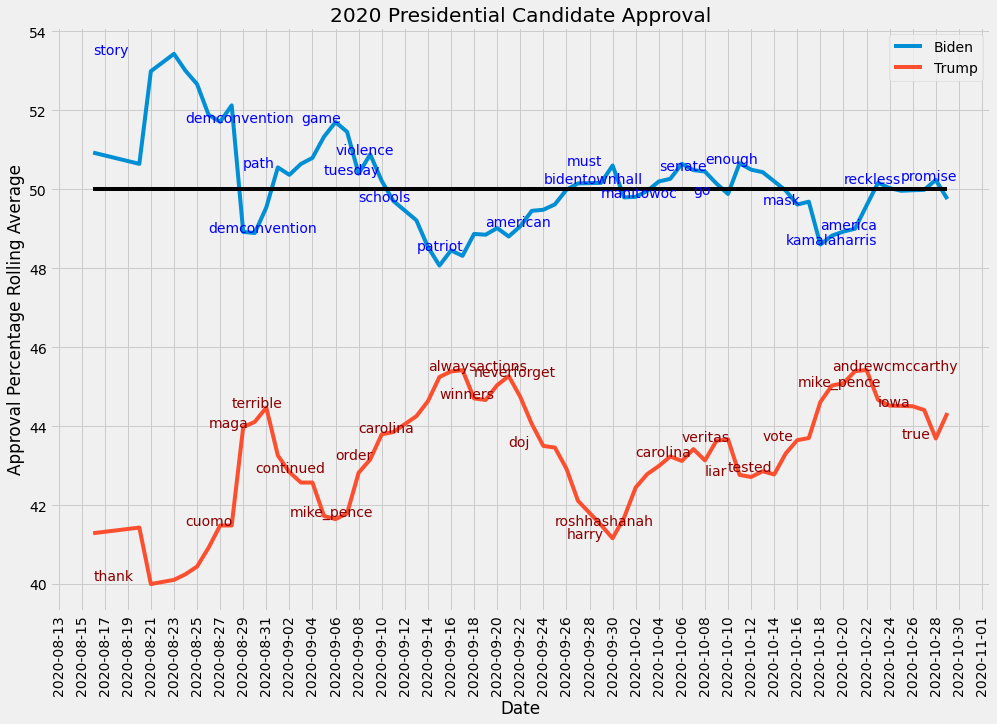

In [38]:
fig, ax = plt.subplots(figsize = (15,10))

## Remove ends of data to account for moving average
plt.plot(elec_post_aug.index[window//2:-((window-1)//2)], running_avg_biden, label='Biden')
plt.plot(elec_post_aug.index[window//2:-((window-1)//2)], running_avg_trump, label='Trump')
plt.plot(elec_post_aug.index[window//2:-((window-1)//2)], [50 for i in elec_post_aug.index[window//2:-((window-1)//2)]], color='black')

location = plticker.MultipleLocator(base=2.0)
ax.xaxis.set_major_locator(location)

plt.xticks(rotation = 90)
plt.xlabel('Date')
plt.ylabel('Approval Percentage Rolling Average')
plt.title('2020 Presidential Candidate Approval')
plt.legend()

for i in range(len(elec_post_aug)):
    if i in noteable_date_biden:
        day = get_day_tfidf(score_df_biden, score_df_biden.index[i])
        label = day.sort_values("TFIDF", ascending = False).iloc[0]["words"]

        ax.annotate(label, (elec_post_aug.index[i], running_avg_biden[i]), color='blue')
        
for i in range(len(elec_post_aug)):
    if i in noteable_date_trump:
        day = get_day_tfidf(score_df_trump, score_df_trump.index[i])
        label = day.sort_values("TFIDF", ascending = False).iloc[0]["words"]
        
        ax.annotate(label, (elec_post_aug.index[i], running_avg_trump[i]), color = 'darkred')

plt.savefig('../output/approval_words_ra.png', bbox_inches = 'tight')
plt.show()